In [200]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

In [201]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
train_data = pd.read_csv('../Auto Pipeline/10_weekly_train.csv')
test_data = pd.read_csv('../Auto Pipeline/10_weekly_test.csv')
train_data.drop(["Date"],1, inplace = True)
test_data.drop(["Date"],1, inplace = True)

In [202]:
train_mov = train_data["movement"]
test_mov = test_data["movement"]
col_name = train_data.drop(["Close (t)","movement"],1).columns
train = train_data.copy()
test = test_data.copy()
train[col_name] = scaler_x.fit_transform(train_data.drop(["Close (t)","movement"],1))
label_train = pd.Series(scaler_y.fit_transform(train_data[["Close (t)"]]).reshape(-1))
test[col_name] = scaler_x.fit_transform(test_data.drop(["Close (t)","movement"],1))
scaled_test = pd.Series(scaler_test.fit_transform(test_data[["Close (t)"]]).reshape(-1))
label_test = test_data["Close (t)"]

In [203]:
def evaluate(test, label_test):
    predicted = test
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    cm = confusion_matrix(label_test, predicted)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
    classification = classification_report(label_test, predicted)
    print(classification)


In [204]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 231, metric='euclidean')
knn_model = knn.fit(train, label_train)


In [205]:
print('kNN R-squared for training set: %f' % knn_model.score(train, label_train))
print('kNN R-squared for test set: %f' % knn_model.score(test, scaled_test))

ypred = knn_model.predict(test)
ypred = scaler_test.inverse_transform(ypred.reshape(-1,1))
ypred = ypred.reshape(-1)

print('kNN MAE for test set: %f' % mean_absolute_error(label_test, ypred))
print('kNN MSE for test set: %f' % mean_squared_error(label_test, ypred, squared=True))
print('kNN RMSE for test set: %f' % mean_squared_error(label_test, ypred, squared=False))


kNN R-squared for training set: 0.955220
kNN R-squared for test set: 0.798434
kNN MAE for test set: 173.957611
kNN MSE for test set: 37758.434139
kNN RMSE for test set: 194.315296


In [206]:

#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = knn_model.predict(train)
ypred_train = scaler_y.inverse_transform(ypred_train.reshape(-1,1))
ypred_train = ypred_train.reshape(-1)
train_move = (ypred_train - train_data["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test_data["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]


accuracy: 0.5847457627118644
precision: 0.5441033547547419
recall: 0.5847457627118644
f1 0.538610477848447
metrics.roc_auc_score 0.5138862061725803
              precision    recall  f1-score   support

           0       0.43      0.20      0.27       275
           1       0.62      0.83      0.71       433

    accuracy                           0.58       708
   macro avg       0.52      0.51      0.49       708
weighted avg       0.54      0.58      0.54       708



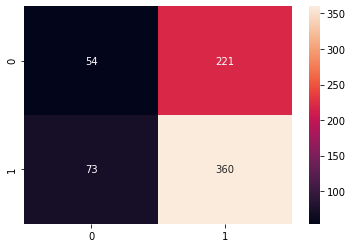

In [279]:
evaluate(test_move, label_test_move)

In [252]:
test_apple = label_test[:236]
test_microsoft = label_test[236:472]
test_google = label_test[472:]

predict_apple = ypred[:236]
predict_microsoft = ypred[236:472]
predict_google = ypred[472:]

test_move_apple = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)[:236]
test_move_microsoft = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)[236:472]
test_move_google = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)[472:]

label_test_move_apple = test_data["movement"][:236]
label_test_move_microsoft = test_data["movement"][236:472]
label_test_move_google = test_data["movement"][472:]



In [253]:
len(test_move)

708

In [254]:
Individual APPL

SyntaxError: invalid syntax (<ipython-input-254-0213680fbac8>, line 1)

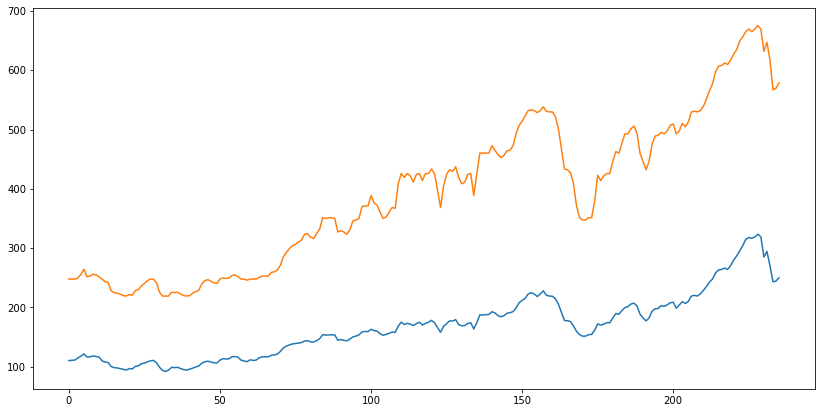

In [255]:
plt.figure(figsize=(14,7))
plt.plot(test_apple)
plt.plot(predict_apple)

In [274]:
print('MAE for Apple: %f' % mean_absolute_error(test_apple, predict_apple))
print('MSE for Apple: %f' % mean_squared_error(test_apple, predict_apple, squared=True))
print('RMSE for Apple: %f' % mean_squared_error(test_apple, predict_apple, squared=False))

MAE for Apple: 200.319732
MSE for Apple: 43968.514298
RMSE for Apple: 209.686705


accuracy: 0.6101694915254238
precision: 0.3723068083883942
recall: 0.6101694915254238
f1 0.4624442462087422
metrics.roc_auc_score 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.61      1.00      0.76       144

    accuracy                           0.61       236
   macro avg       0.31      0.50      0.38       236
weighted avg       0.37      0.61      0.46       236



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classificati

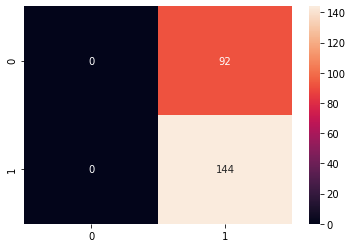

In [280]:
evaluate(test_move_apple, label_test_move_apple)

In [258]:
Individual GOOGLE

SyntaxError: invalid syntax (<ipython-input-258-5d0312cfb0f0>, line 1)

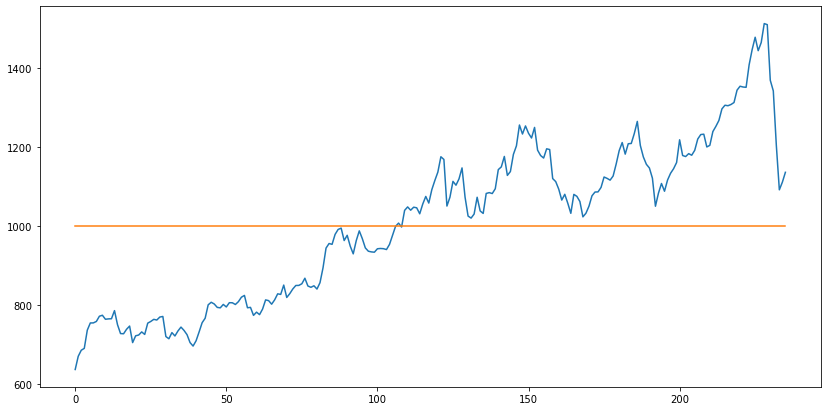

In [259]:
plt.figure(figsize=(14,7))
test_google = pd.DataFrame(test_google).reset_index()
del test_google['index']
plt.plot(test_google)

predict_google = pd.DataFrame(predict_google).reset_index()
del predict_google['index']
plt.plot(predict_google)

In [275]:
print('MAE for Google: %f' % mean_absolute_error(test_google, predict_google))
print('MSE for Google: %f' % mean_squared_error(test_google, predict_google, squared=True))
print('RMSE for Google: %f' % mean_squared_error(test_google, predict_google, squared=False))

MAE for Google: 150.994441
MSE for Google: 33603.270211
RMSE for Google: 183.311948


accuracy: 0.5932203389830508
precision: 0.3519103705831657
recall: 0.5932203389830508
f1 0.4417598269022719
metrics.roc_auc_score 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.59      1.00      0.74       140

    accuracy                           0.59       236
   macro avg       0.30      0.50      0.37       236
weighted avg       0.35      0.59      0.44       236



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classificati

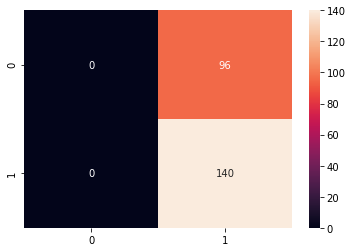

In [281]:
evaluate(test_move_google, label_test_move_google)

In [262]:
len(label_test_move_google)

236

In [263]:
MICROSOFT

NameError: name 'MICROSOFT' is not defined

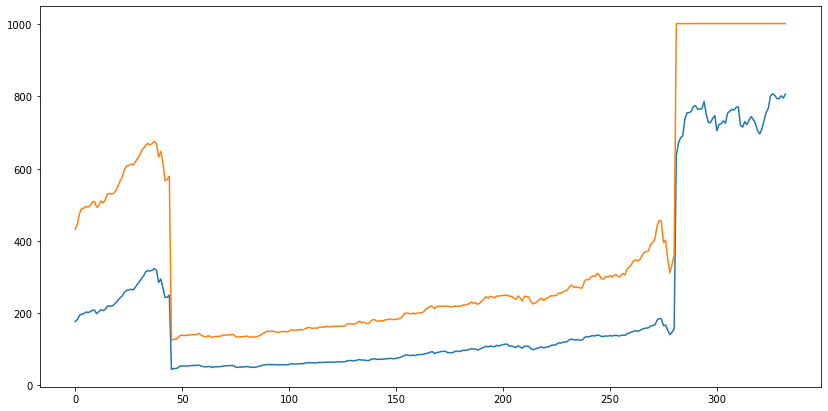

In [278]:
plt.figure(figsize=(14,7))
test_microsoft = pd.DataFrame(test_microsoft).reset_index()
del test_microsoft['index']
plt.plot(test_microsoft)

predict_microsoft = pd.DataFrame(predict_microsoft).reset_index()
del predict_microsoft['index']
plt.plot(predict_microsoft)

In [276]:
print('MAE for Microsoft: %f' % mean_absolute_error(test_microsoft, predict_microsoft))
print('MSE for Microsoft: %f' % mean_squared_error(test_microsoft, predict_microsoft, squared=True))
print('RMSE for Microsoft: %f' % mean_squared_error(test_microsoft, predict_microsoft, squared=False))

MAE for Microsoft: 171.525353
MSE for Microsoft: 36492.442704
RMSE for Microsoft: 191.029952


accuracy: 0.6313559322033898
precision: 0.39861031312841133
recall: 0.6313559322033898
f1 0.4886858903808056
metrics.roc_auc_score 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.63      1.00      0.77       149

    accuracy                           0.63       236
   macro avg       0.32      0.50      0.39       236
weighted avg       0.40      0.63      0.49       236



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classificati

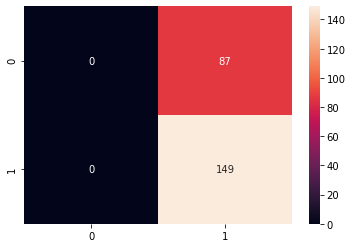

In [282]:
evaluate(test_move_microsoft, label_test_move_microsoft)